## A few things we'll (probably) need

([`kneed`](https://pypi.org/project/kneed/) is a module for [detecting 'knee points'](https://raghavan.usc.edu//papers/kneedle-simplex11.pdf))  

In [3]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
        
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')

## An example of k-means clustering using `sklearn`

(the [Sleep Health and Lifestyle dataset](https://data.world/andrewpyong/sleep-health) from data.world)

In [6]:
#######################
#  Read, wrangle...   #
#######################

# This dataset was taken from 
# https://data.world/andrewpyong/sleep-health/

df = pd.read_csv('../../data/Sleep_health_and_lifestyle_dataset.csv')

# The label encoder is used to transform categorical 
# data to numerical labels 
le = LabelEncoder()
df['Sleep Disorder label'] = le.fit_transform(df['Sleep Disorder'])

# We won't need these columns: 
df.drop(['Person ID', 'Gender', 'Occupation', 
         'BMI Category'], axis=1, inplace=True)
# df.drop(['Sleep Disorder'], axis=1, inplace=True)

df.head()

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Blood Pressure 1,Blood Pressure 2,Heart Rate,Daily Steps,Sleep Disorder,BMI Levels,Sleep Disorder label
0,27,6.1,6,42,6,126,83,77,4200,NaN,2,2
1,28,6.2,6,60,8,125,80,75,10000,NaN,1,2
2,28,6.2,6,60,8,125,80,75,10000,NaN,1,2
3,28,5.9,4,30,8,140,90,85,3000,Sleep Apnea,3,1
4,28,5.9,4,30,8,140,90,85,3000,Sleep Apnea,3,1


## Feature scaling

The k-means algorithm uses **distances from points (centroids)**. 

Different features with different units and scales would be weighted differently if not normalized.   

In [5]:
################################
#  Rescaling (standardizing)   #
# since k-means uses distances #
################################

features = ['Sleep Duration', 'Quality of Sleep']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

df.loc[:, features] = scaled_features

df.head()

/var/folders/tq/gj38l6153ks1cvmr6crxqg_00000gp/T/ipykernel_28326/214233063.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.09828011 -1.09828011 -1.09828011 -2.77142374 -2.77142374 -2.77142374
 -1.09828011 -0.26170829 -0.26170829 -0.26170829 -1.09828011 -0.26170829
 -1.09828011 -1.09828011 -1.09828011 -1.09828011 -1.93485192 -1.09828011
 -1.93485192 -0.26170829 -0.26170829 -0.26170829 -0.26170829 -0.26170829
 -0.26170829 -0.26170829 -0.26170829 -0.26170829 -0.26170829 -0.26170829
 -1.93485192 -1.93485192  0.57486352 -1.09828011 -0.26170829 -1.09828011
 -1.09828011 -0.26170829 -0.26170829 -0.26170829 -0.26170829 -0.26170829
 -0.26170829 -0.26170829 -0.26170829 -0.26170829 -0.26170829 -0.26170829
 -0.26170829 -0.26170829  0.57486352  0.57486352 -1.09828011 -0.26170829
 -1.09828011 -1.09828011 -0.26170829 -1.09828011 -1.09828011 -0.26170829
 -1.09828011 -1.09828011 -1.09828011 -1.09828011 -1.09828011 -1.098280

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Blood Pressure 1,Blood Pressure 2,Heart Rate,Daily Steps,Sleep Disorder,BMI Levels,Sleep Disorder label
0,27,-1.298887,-1.098280,42,6,126,83,77,4200,NaN,2,2
1,28,-1.173036,-1.098280,60,8,125,80,75,10000,NaN,1,2
2,28,-1.173036,-1.098280,60,8,125,80,75,10000,NaN,1,2
3,28,-1.550588,-2.771424,30,8,140,90,85,3000,Sleep Apnea,3,1
4,28,-1.550588,-2.771424,30,8,140,90,85,3000,Sleep Apnea,3,1


**Some parameters:** 
* `n_clusters`: the desired number of clusters. 
* `n_init`: the number of times to run the entire algorithm (we'll see why below). 
* `max_iter`: maximal number of iterations if the algorithm doesn't converge before that. 

**Some attributes:** 
* `kmeans.cluster_centers_`: the centeroids of the clusters.
* `kmeans.labels_`: the labels of the clusters (integers by default). 
* `kmeans.inertia_`: the lowest SSE (discussed below) found in `n_init` runs. <br/> The lesser the model inertia, the better the model fit.

**The k-means algorithm:** 
* It is actually quite simple (naive, even).  
* It will be discussed a bit later, after a few examples.

The lowest SSE value found: 111.313
The number of iterations required to converge: 7


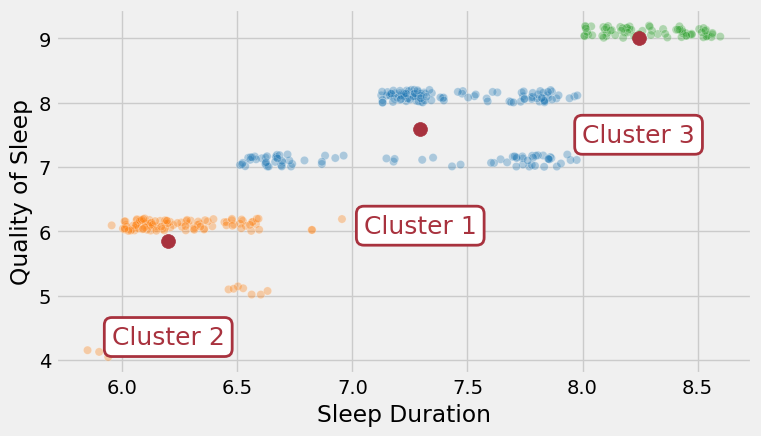

In [7]:
###################
# Train the model #
###################

features = ['Sleep Duration', 'Quality of Sleep']
n_clusters = 3
kmeans = KMeans(init='random', n_clusters=n_clusters,
                n_init=10, max_iter=300)
kmeans.fit(df[features])
print('The lowest SSE value found: %.3f'%kmeans.inertia_)
print('The number of iterations required to converge: %d'%\
      kmeans.n_iter_)

fig, ax = plt.subplots(figsize=(8, 4.5))
# Plot and add jitter for better visualization
ax = sns.scatterplot(ax=ax, 
                x=df[features[0]]+np.random.rand(len(df))*0.1, 
                y=df[features[1]]+np.random.rand(len(df))*0.2,
                hue=kmeans.labels_, 
                palette=sns.color_palette('tab10', 
                                          n_colors=n_clusters),
                legend=None, alpha = 0.33)

for n, [dur, qual] in enumerate(kmeans.cluster_centers_):
    ax.scatter(dur, qual, s=100, c='#a8323e')
    ax.annotate('Cluster %d'%(n+1), (dur, qual), fontsize=18,
                color='#a8323e', xytext=(dur, qual-1.5),
                bbox=dict(boxstyle='round,pad=0.3', 
                          fc='white', ec='#a8323e', lw=2),
                ha='center', va='center');




But perhaps the data would more naturally divide to $4$ clusters... Or $5$... Or $2$... 

<br/> 

<br/> 

<br/> 


## Choosing the number of clusters (k) 

### The elbow method

The quality of the cluster assignments is (often) evaluated by the **sum of the squared error (SSE)** from the centroids: 

$$
\begin{aligned} 
SSE &=& \hspace{-3mm} \sum_{i \in \text{data points}} \ \sum_{j \in \text{features}} \left( \text{feature$_j$ of point$_i$} - \text{feature$_j$ of closest centroid to point$_i$} \right)^2 \\
&=& \sum_{i \in \text{data points}} \ \left( \text{distance of point$_i$ from its closest centroid} \right)^2
\end{aligned}
$$ 


* `sklearn` stores the SSE in the attribute `inertia_` of the `sklearn.cluster.KMeans` object: 

Automatically found elbow at 4 clusters.


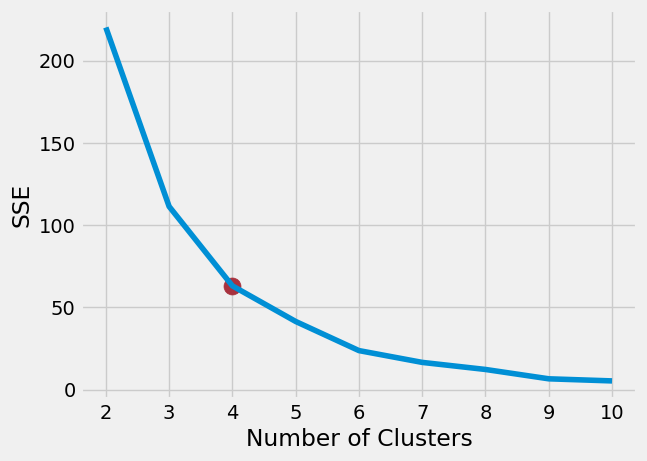

In [8]:
#########################
# Find k - elbow method #
#########################

features = ['Sleep Duration', 'Quality of Sleep']
kmeans_kwargs = {'init': 'random', 'n_init': 10, 
                 'max_iter': 300}

k_vals = list(range(2, 11))
sse = []
for k in k_vals:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df[features])
    sse.append(kmeans.inertia_)
    
kl = KneeLocator(k_vals, sse, curve='convex', 
                 direction='decreasing')
print('Automatically found elbow at %d clusters.'%kl.elbow)

plt.plot(k_vals, sse)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')  
plt.scatter(kl.elbow, kl.elbow_y, s=150, c='#a8323e');

## The Silhouette method


* The silhouette index, $-1 \leq s \leq 1$,  is a measure of how similar a sample is to its own cluster compared to other clusters. 

$$\begin{aligned}
s(i) &=& \frac{b(i) - a(i)}{\max\{a(i), b(i) \}} \\
\text{ where:} &&  \\ 
a(i) &=& \text{the mean distance between sample $i$ and} \\
&& \hspace{1mm} \text{all other samples in the same cluster (ideally small)} \\ 
b(i) &=& \text{the smallest mean distance of sample $i$ to} \\
&& \hspace{1mm} \text{the points in any other cluster (ideally large)} 
\end{aligned}$$

<img src="https://github.com/david-biron/DATA221imgs/blob/main/SilhouetteSketch.png?raw=true" width="400">

* A high index indicates that the sample is well matched to its own cluster and poorly matched to neighboring clusters. 
* A high average index suggests reasonable clustering. 
* Many samples with a low index suggests too many or too few clusters (or wrong clustering method).

<br>

#### Note:

The silhouette method considers both within-cluster and between-cluster distance.

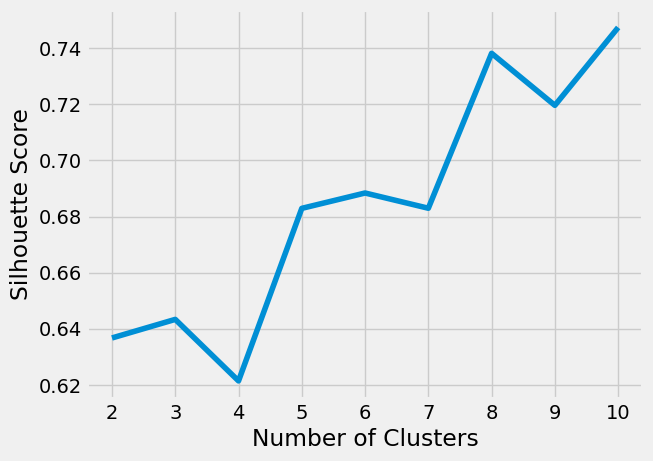

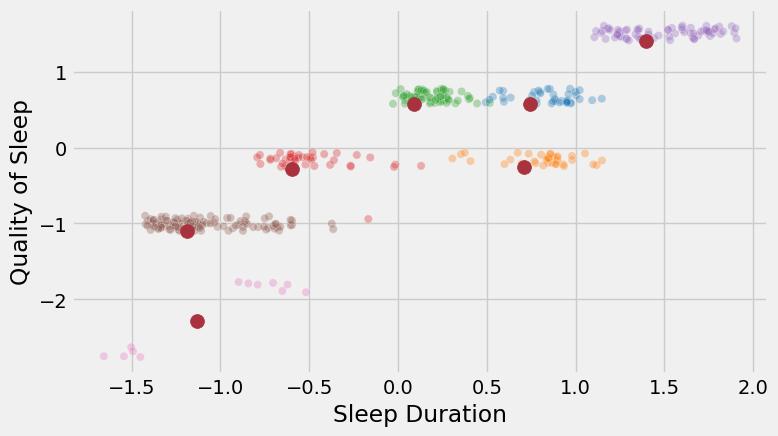

In [8]:
features = ['Sleep Duration', 'Quality of Sleep']
silhouette_coefficients = []

# The average silhouette coefficient of all the samples 
# is summarized into one score.
silhouette_coefficients = []
for k in k_vals:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df[features])
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)
    
plt.plot(k_vals, silhouette_coefficients)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score');

############################
# Let's try more clusters: #
############################

n_clusters = 7
kmeans = KMeans(init='random', n_clusters=n_clusters,
                n_init=10, max_iter=300)
kmeans.fit(df[features])

fig, ax = plt.subplots(figsize=(8, 4.5))
# Plot and add jitter for better visualization
ax = sns.scatterplot(ax=ax, 
                x=df[features[0]]+np.random.rand(len(df))*0.2, 
                y=df[features[1]]+np.random.rand(len(df))*0.2,
                hue=kmeans.labels_, 
                palette=sns.color_palette('tab10', 
                                          n_colors=n_clusters),
                legend=None, alpha = 0.33)

for n, [dur, qual] in enumerate(kmeans.cluster_centers_):
    ax.scatter(dur, qual, s=100, c='#a8323e');




#### The silhouette score is higher for $7$ clusters than $3$ but: 

* The difference is not huge ($0.74$ vs. $0.64$). 
* $7$ clusters is a considerably more complex model than $3$.
* Can we justify $7$ clusters with domain knowledge? (my guess: no, but perhaps). 
* Elbow method does suggests $4$ clusters... 

This decision involves a judgement call but - absent additional domain knowledge - it is reasonable to stick with $k=4$. 


## Split the data into training and testing sets?

* If the **goal is to cluster** the data, examine the clusters, and interpret/use the resulting division  then there may be no need to set aside a testing dataset.   

* If the **goal is prediction**, i.e., the clusters feed into a supervised learning model (as a feature) or otherwise used to predict an outcome then putting aside a testing dataset is advisable. 



## The k-means algorithm

Given the number of clusters ($k$):
* Randomly initialize $k$ centroids.
* Repeat
    * Assign each point to its closest centroid.
    * Compute the new centroid of each cluster.
* Until The centroid positions do not change (much).

### Note: 

The k-means algorithm is **not deterministic** - different initializations of the centroids may produce different clusters. Therefore, the entire algorithm is run several times (`n_init=10` by default in `sklearn`) and the centroids that give the lowest SSE are chosen.  

<br> 
<br> 

For instance, the following figure shows $2$ initializations that coverge after $5$ iterations. <br/>  The one on the right hand side ends up with a **lower SSE** and would therefore be preferred. 

<br> 

![kmeansgif](https://github.com/david-biron/DATA221imgs/blob/main/Clustering_centroids_iterations.gif?raw=true)



### Pros 
* Somewhat computationally efficient and can be modified to be more so (see [`MiniBatchKMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html)).
* Easily implemented and tweaked such that many cons can be fixed (at least for some datasets). 
* Methods like [Hierarchical clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering) are time consuming for large datasets. <br/> K-means cluster centers can be used as input to another clustering algorithm to  significantly save time and detect non-convex clusters (see below).
* K-Means cluster centers can be used as Initialization to [Gaussian Mixture Models (GMMs)](https://en.wikipedia.org/wiki/Mixture_model). 
* K-means can naturally be used for anomaly detection: large distances from the center would be suspect... 
* K-means can itself be used for dimensional reduction (see below). 

### Cons 
* $k$ is chosen in advance. 
* The **curse of dimentionality**: In high-dimensional spaces euclidean distances between (random) points are more narrowly distributed. 

| | | 
|:-:|:-:|
| <img src="https://github.com/david-biron/DATA221imgs/blob/main/DistancesInHighDims.png?raw=true" width="500"> | $\rightarrow$ <br/> k-means is less effective at distinguishing between data points <br/> (the curse of dimensionality).| 

**Dimensionality reduction** can help. 

* K-means can be slow for large numbers of samples since it calculates distances from each sample. <br/> Batch-based k-means, e.g., `sklearn.cluster.MiniBatchKMeans`, relax this requirement. 
* K-Means is susceptible to outliers since centroids are updated with *mean* values.<br/> K-modes or k-medoids (chooses actual data points as centers) are less so. 

* Does not work well when the cluster shapes are not compact (“ball-like”), e.g., if they have  “holes” or “fjords” and penetrate one another. <br/> See, e.g., [`datasets.make_circles`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html#sklearn.datasets.make_circles), [`datasets.make_moons`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html#sklearn.datasets.make_moons), and [here](https://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html#sphx-glr-auto-examples-cluster-plot-linkage-comparison-py). <br/> No easy fix for this issue. 




## Dimensionality reduction

|   |   |
|:--|:--|
| <img src="https://github.com/david-biron/DATA221imgs/blob/main/icon_definition.png?raw=true" width="50" height=""> | **Dimensionality reduction** algorithms are  unsupervised learning algorithms that <br> reduce the number of attributes which represent each point in a dataset. <br> The goal, of course, is to keep as much of the variation (information) in the <br> original dataset as possible. |

|   |   |
|:--|:--|
| <img src="https://github.com/david-biron/DATA221imgs/blob/main/icon_comment.png?raw=true" width="50" height=""> | By and large, dimensionality reduction is used as a **data preprocessing step** <br> prior to training another model (with the reduced number of features). |




## Dimensionality reduction I: <br> Principal Component Analysis (PCA) 

### Principal Component Analysis - brief background 

**Principal Components Analysis (PCA)** is an unsupervised dimensionality reduction algorithm.  

PCA constructs ($n$) new features through **linear** combinations of the ($n$) original ones, but... <br/> The algorithm:
* Determines which linear combinations of the original features would result in **uncorrelated (new) features, called principal components**.
* Determines how **much of the variability** of the original data remains in each of the new features. 
* The **first** principal component explains the **most variability** in the data and each subsequent component explains less.
* Allows to pick **fewer (new) features** than the number of original features while **capturing most of the variability** of the data.  


### Example: the Sleep Health and Lifestyle dataset

In [9]:
df.head()

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Blood Pressure 1,Blood Pressure 2,Heart Rate,Daily Steps,Sleep Disorder,BMI Levels,Sleep Disorder label
0,27,-1.298887,-1.098280,42,6,126,83,77,4200,NaN,2,2
1,28,-1.173036,-1.098280,60,8,125,80,75,10000,NaN,1,2
2,28,-1.173036,-1.098280,60,8,125,80,75,10000,NaN,1,2
3,28,-1.550588,-2.771424,30,8,140,90,85,3000,Sleep Apnea,3,1
4,28,-1.550588,-2.771424,30,8,140,90,85,3000,Sleep Apnea,3,1


In [10]:
features = [f for f in df.columns \
            if f!='Sleep Disorder' and f!='Sleep Disorder label']
df[features].shape

(374, 10)

In [11]:
scaler.fit_transform(df[features]).shape

(374, 10)

### PCA with `sklearn`

/var/folders/tq/gj38l6153ks1cvmr6crxqg_00000gp/T/ipykernel_28326/211359107.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.75309569 -1.63764266 -1.63764266 -1.63764266 -1.63764266 -1.63764266
 -1.52218962 -1.52218962 -1.52218962 -1.52218962 -1.52218962 -1.52218962
 -1.52218962 -1.52218962 -1.52218962 -1.52218962 -1.52218962 -1.52218962
 -1.52218962 -1.40673658 -1.40673658 -1.40673658 -1.40673658 -1.40673658
 -1.40673658 -1.40673658 -1.40673658 -1.40673658 -1.40673658 -1.40673658
 -1.40673658 -1.40673658 -1.29128355 -1.29128355 -1.29128355 -1.29128355
 -1.29128355 -1.29128355 -1.29128355 -1.29128355 -1.29128355 -1.29128355
 -1.29128355 -1.29128355 -1.29128355 -1.29128355 -1.29128355 -1.29128355
 -1.29128355 -1.29128355 -1.17583051 -1.17583051 -1.17583051 -1.17583051
 -1.17583051 -1.17583051 -1.17583051 -1.17583051 -1.17583051 -1.17583051
 -1.17583051 -1.17583051 -1.17583051 -1.17583051 -1.17583051 -1.1758305

array([0.37655605, 0.68811197, 0.86224736, 0.92416235, 0.95195404,
       0.97695638, 0.98701002, 0.99484609, 0.99878224, 1.        ])

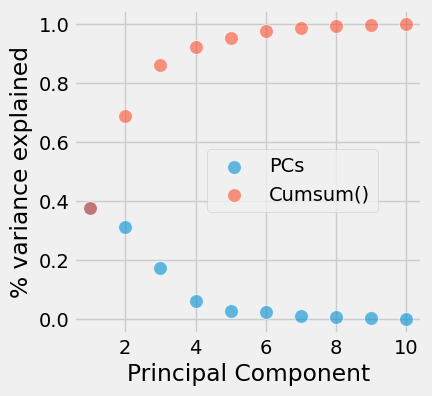

In [12]:
from sklearn.decomposition import PCA

################################
#  Rescaling (standardizing)   #
################################

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])
df.loc[:, features] = scaled_features

################################
#  PCA - find components and   #
#     explained variances      #
################################

N = len(features)
model = PCA(n_components=N)
model.fit(df[features])

plt.figure(figsize=(4,4))
sns.scatterplot(x=range(1,N+1), 
                y=model.explained_variance_ratio_, 
                s=100,
               alpha=0.6) # % of variance explained by each PC
sns.scatterplot(x=range(1,N+1), 
                y=model.explained_variance_ratio_.cumsum(), 
                s=100, alpha=0.6)
plt.xlabel('Principal Component')
plt.ylabel('% variance explained')
plt.legend(['PCs', 'Cumsum()'], bbox_to_anchor=[0.9, 0.6])
model.explained_variance_ratio_.cumsum()


### Clustering the principal components with `sklearn`

Suppose we'd like to use the data for predictions. 

If so, best split the data to a training and testing set. 



Automatically found elbow at 5 clusters.


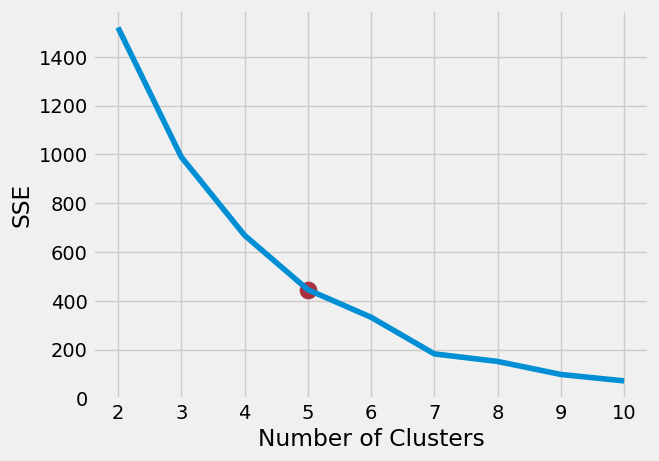

In [13]:
##################################
# K-means with the first two PCs #
##################################

model = PCA(n_components=2) # redundant now,  
model.fit(df[features])     # but good practice if 
                            # inverse_transform is required
pcs_df = model.transform(df[features])
df['PC1'] = pcs_df[:,0]
df['PC2'] = pcs_df[:,1]
# df['PC3'] = pcs_df[:,2]
# df['PC4'] = pcs_df[:,3]
new_features = ['PC1', 'PC2']

#########################
# Find k - elbow method #
#########################

kmeans_kwargs = {'init': 'random', 'n_init': 10, 
                 'max_iter': 300}
sse = []
for k in k_vals:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df[new_features])
    sse.append(kmeans.inertia_)
    
kl = KneeLocator(k_vals, sse, curve='convex', direction='decreasing')
print('Automatically found elbow at %d clusters.'%kl.elbow)

plt.plot(k_vals, sse)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')  
plt.scatter(kl.elbow, kl.elbow_y, s=150, c='#a8323e');



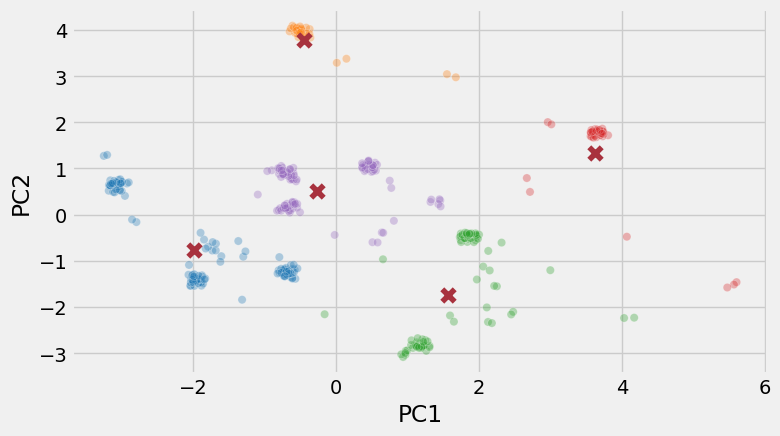

In [14]:
new_features = ['PC1', 'PC2']
n_clusters = 5
kmeans = KMeans(init='random', n_clusters=n_clusters,
                n_init=10, max_iter=300)
kmeans.fit(df[new_features])

fig, ax = plt.subplots(figsize=(8, 4.5))
# Plot and add jitter for better visualization
ax = sns.scatterplot(ax=ax, 
                x=df[new_features[0]]+np.random.rand(len(df))*0.2, 
                y=df[new_features[1]]+np.random.rand(len(df))*0.2,
                hue=kmeans.labels_, 
                palette=sns.color_palette('tab10', 
                                          n_colors=n_clusters),
                legend=None, alpha = 0.33)

for n, [pc1, pc2] in enumerate(kmeans.cluster_centers_):
    ax.scatter(pc1, pc2, s=80, marker='x', c='#a8323e');



#### Further exploration would require domain knowledge. 

It may be that a particular $4 \leq k \leq 9$ clusters makes sense. <br/> Figuring it out would require exammining the clusters more closely and using **domain knowledge**. 

Using more PCs (that explain more variability) could be tried but... 

<br> 

### These data may not be grouped into *linearly separable clusters*.  



## Dimensionality reduction II: <br> t-distributed Stochastic Neighbor Embedding (tSNE)

(pronounced tee-snee)

### t-distributed Stochastic Neighbor Embedding (tSNE) - <br> brief background

**t-Distributed Stochastic Neighbor Embedding (tSNE)** is another unsupervised dimensionality reduction algorithm. 

In contrast to PCA, tSNE is not linear: 
* It **maps** each data record to a $2d$ or $3d$ space 
* It can work well when the original high dimensional data is near a **low dimensional manifold** (think about a sheet or ribbon in $3d$ space. 
* It does **not** require the manifold to be linear (a plane, for instance). <br/>  Thus, it can separate data that cannot be separated by a line/plane. 
* It **preserves pairwise similarities between data points**: the low dimensional representations of points that were originally close (or far) on the manifold remains close (or far). 



### For instance

<img src="https://github.com/david-biron/DATA221imgs/blob/main/NonLinearManifolds.png?raw=true" width="500">

* In the 'swiss-roll' nonlinear manifold (a), the Euclidean distance between two points in the red and blue clusters can be small. 
* A linear dimensionality reduction scheme would conclude that such data points belong nearby (in the low dimensional representation) because they were originally close.
* If the (non-linear) algorithm 'rolls the manifold out into a flat $2d$ shape' the red points would actually be on the opposite end to the blue points, i.e., far away. 

(See [here](https://medium.com/@pajakamy/dimensionality-reduction-t-sne-7865808b4e6a) for more details). 

### Clustering the coordinates of the 2d (or 3d) tSNE mapping with `sklearn`

Automatically found elbow at 4 clusters.


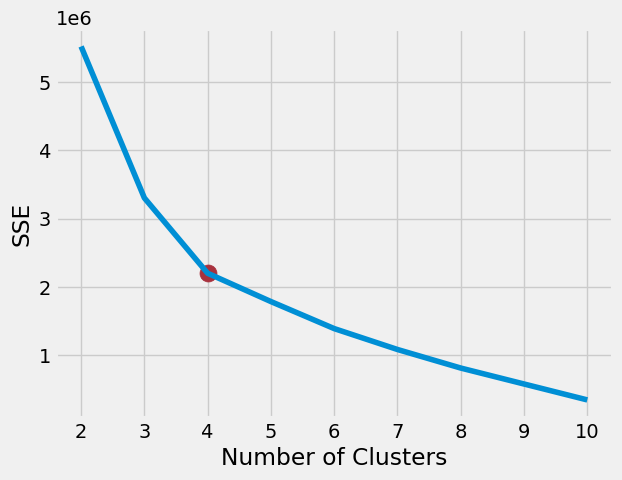

In [24]:
######################
# tSNE mapping to 2d #
######################

from sklearn.manifold import TSNE
import warnings
# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

model = TSNE(n_components=2, random_state=42)
X_tsne = model.fit_transform(df[features]).T
df['tSNE1'] = X_tsne[0]
df['tSNE2'] = X_tsne[1]

new_features = ['tSNE1', 'tSNE2']

#########################
# Find k - elbow method #
#########################

kmeans_kwargs = {'init': 'random', 'n_init': 10, 
                 'max_iter': 300}
sse = []

k_vals = list(range(2, 11))
for k in k_vals:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df[new_features])
    sse.append(kmeans.inertia_)
    
kl = KneeLocator(k_vals, sse, curve='convex', direction='decreasing')
print('Automatically found elbow at %d clusters.'%kl.elbow)

plt.plot(k_vals, sse)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')  
plt.scatter(kl.elbow, kl.elbow_y, s=150, c='#a8323e');




#### Perplexity and KL divergence

**Perplexity** is a hyperparameter of the t-SNE algorithm. <br/> It determines number of neighbors that each point considers during the mapping. 

**KL Divergence** is a metric pertaining to the similarity between distances (mapped to probabilities) in the high dimensional and low dimensional representations of the data.

In [25]:
print('Perplexity=%.2f'%model.perplexity)
print('KL divergence=%.2f'%model.kl_divergence_)

Perplexity=30.00
KL divergence=-0.98


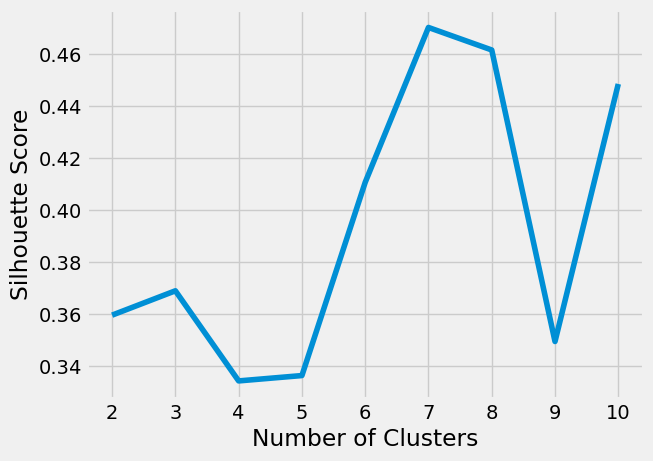

In [26]:
new_features = ['tSNE1', 'tSNE2']

#########################
#  Find k - silhouette  #
#########################

plt.figure()
silhouette_coefficients = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df[features])
    score = silhouette_score(df[new_features], kmeans.labels_)
    silhouette_coefficients.append(score)
    
plt.plot(range(2, 11), silhouette_coefficients)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score');




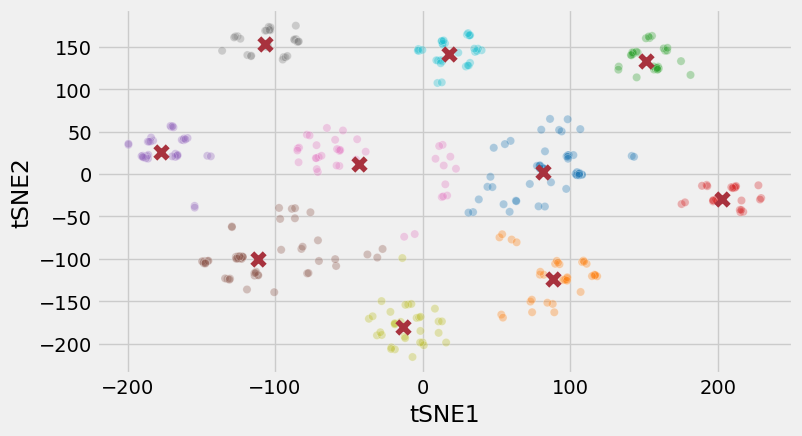

In [29]:
new_features = ['tSNE1', 'tSNE2']

n_clusters = 10
kmeans = KMeans(init='random', n_clusters=n_clusters,
                n_init=10, max_iter=300)
kmeans.fit(df[new_features])

fig, ax = plt.subplots(figsize=(8, 4.5))
# Plot and add jitter for better visualization
ax = sns.scatterplot(ax=ax, 
                x=df[new_features[0]]+np.random.rand(len(df))*5, 
                y=df[new_features[1]]+np.random.rand(len(df))*5,
                hue=kmeans.labels_, 
                palette=sns.color_palette('tab10', 
                                          n_colors=n_clusters),
                legend=None, alpha = 0.33)

for n, [pc1, pc2] in enumerate(kmeans.cluster_centers_):
    ax.scatter(pc1, pc2, s=80, marker='x', c='#a8323e');



#### The clusters definitely look separable and $k=10$ seems more reasonable than $k=4$. 

But again, domain knowledge would be required to judge whether the clusters are meaningful. 


### Additional (cute) examples can be found [here](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html). 

### Searching for a good (non-default) value of perplexity: 

CPU times: user 50 s, sys: 7.5 s, total: 57.5 s
Wall time: 7.7 s


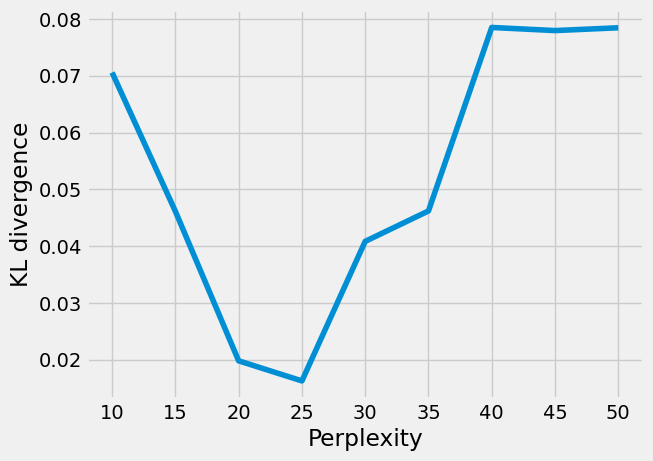

In [31]:
%%time 

perplexity = np.arange(10, 55, 5)
divergence = []

for i in perplexity:
    model = TSNE(n_components=2, init='random', perplexity=i)
    model.fit_transform(df[new_features])
    divergence.append(model.kl_divergence_)
fig = sns.lineplot(x=perplexity, y=divergence)
plt.xlabel('Perplexity') 
plt.ylabel('KL divergence');


## BTW, K-means itself can be used for Non Linear Dimensionality Reduction

* Fit k-Means to data. The number of clusters, $k$, is the *desired number of dimensions*.
* Calculate the distances of each data point from each cluster center. <br/> Each data point will be represented by $k$ distances, i.e., $k$ (new) features. 
* In `sklearn`, [`kmeans.transform()`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.transform) calculates these distances for the entire dataset. 


## Other unsupervised clustering algorithms (in brief)

### DBSCAN clustering 

Used to:
* Identify clusters that 'penetrate' each other's space. 
* Separate clusters of high density from clusters of low density.

In brief: 
* Unsupervised. 
* Does **not** require the number of clusters. 
* Input: 
    * **Epsilon** -  the radius of the sphere to be created around each data point to check the density around it. 
    * **minPoints** - the minimum number of data points required inside that sphere for that data point to be classified.
* Groups together neighboring points (in a greedy way). 
* Robust to outliers (ignores them). 
* Does not perform well in high dminsions. 

For instance: 
![DBSCANgif](https://github.com/david-biron/DATA221imgs/blob/main/Clustering_DBSCAN.gif?raw=true) 

(https://images.datacamp.com/image/upload/v1659712766/DBSCAN_729493b2ee.gif)



### Mean Shift Clustering 

Used to:
* Mean Shift is a mode-seeking algorithm: centroids of clusters will be at peak densities of data points. 
* Image processing. 

In brief: 
* Unsupervised. 
* Does **not** require the number of clusters. 
* Does not require predefined shape of clusters (a somewhat fixable problem in k-means). 
* Input: 
    * A set of points. 
    * A **bandwidth** parameter - the radius of the sphere in which the density will be calculated. 
* Mean Shift 
    * Iteratively nudged each center towards regions of higher density by shifting it to the mean of the points within the sphere. 
    * This process is repeated until spheres don't move much. 
    * Overlapping spheres are discarded - only the one with the most data points is kept.  
    * Data points are then assigned clusters according to the nearest center. 
* Slower than k-means (run time scales more poorly: $O(iter \times n^2)$ instead of $O(iter \times k \times n)$ for k-means).     

For instance: 
![MeanShiftgif](https://github.com/david-biron/DATA221imgs/blob/main/Clustering_mean_shift.gif?raw=true)




#### There are more... 